In [1]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW, AlbertTokenizer, AlbertConfig, AlbertModel
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from sklearn import metrics

In [2]:
train_data = pd.read_csv('/kaggle/input/ruatd-2022-bi/train.csv')
train_data.head(2)
train_data['Text'] = train_data['Text'].apply(lambda x: x.replace('\n', ' '))
train_data['Text'] = train_data['Text'].apply(lambda x: x.replace('\xa0', ' '))
train_data['Text'] = train_data['Text'].apply(lambda x: x.replace('\\t', ' '))
train_text = train_data.Text
train_labels = train_data['Class']

In [10]:
train_data.loc[160]

Id                                                     267
Text     А еще военком предлагает повысить зарплату пре...
Class                                                    H
Name: 160, dtype: object

In [11]:
train_data.iloc[160]['Text']

'А еще военком предлагает повысить зарплату преподавателям школьного курса "Основы безопасности жизни", чтоб их заиннтересовать.'

In [7]:
test_data = pd.read_csv('/kaggle/input/ruatd-2022-bi/val.csv')
test_data.head(2)
test_data['Text'] = test_data['Text'].apply(lambda x: x.replace('\n', ' '))
test_data['Text'] = test_data['Text'].apply(lambda x: x.replace('\xa0', ' '))
test_data['Text'] = test_data['Text'].apply(lambda x: x.replace('\\t', ' '))
test_text = test_data.Text
test_labels = test_data['Class']

In [8]:
final_test_data = pd.read_csv('/kaggle/input/ruatd-2022-bi/test.csv')
final_test_data.head(2)
final_test_data['Text'] = final_test_data['Text'].apply(lambda x: x.replace('\n', ' '))
final_test_data['Text'] = final_test_data['Text'].apply(lambda x: x.replace('\xa0', ' '))
final_test_text = final_test_data.Text
# final_test_labels = final_test_data['Class']
len(final_test_text)

64533

In [9]:
len(train_labels)

129066

In [10]:
test_labels.unique()

array(['H', 'M'], dtype=object)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


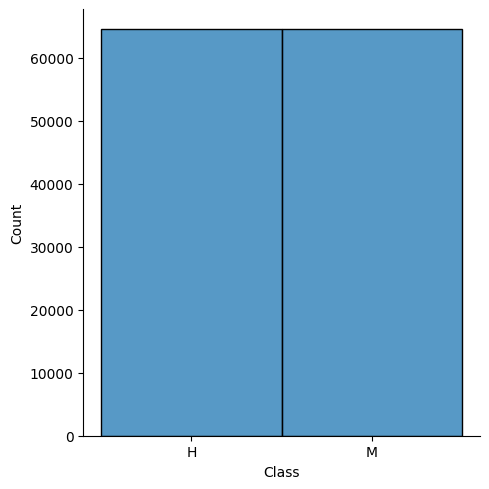

In [11]:
sns.displot(train_labels)

In [12]:
train = pd.concat([train_text, train_labels], sort=False, axis=1)
test = pd.concat([test_text, test_labels], sort=False, axis=1)

In [13]:
train['Class'] = train['Class'].astype(str)
test['Class'] = test['Class'].astype(str)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


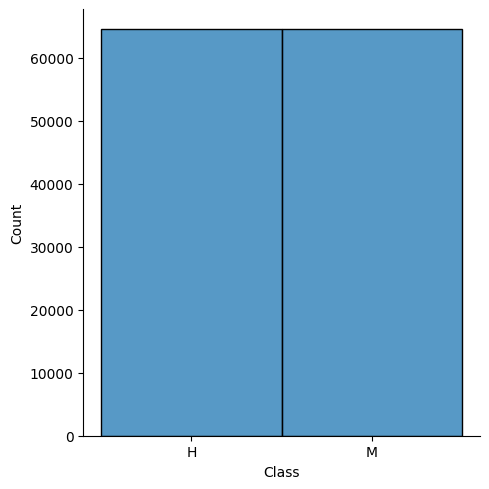

In [14]:
sns.displot(train['Class'])

In [15]:
for i in ['H', 'M']:
    train[i] = train['Class'].apply(lambda x: 1 if i in x else 0)
    test[i] = test['Class'].apply(lambda x: 1 if i in x else 0)

In [16]:
train.drop(['Class'], axis=1, inplace=True)
test.drop(['Class'], axis=1, inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [17]:
train.head(2)

,Text,H,M
0,"Обустройство тротуаров, мостовых (в том числе ...",1,0
1,Въ издержкахъ же оныхъ вы имете присылать счет...,1,0


In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
target_cols = [col for col in train.columns if col not in ['Text']]
# target_cols = 'label'
target_cols

['H', 'M']

-------------------------------

In [20]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained('blinoff/roberta-base-russian-v0', max_len=512)

tokenizer_config.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [21]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

In [22]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [23]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)
train_for_test_loader = DataLoader(train_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [25]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('blinoff/roberta-base-russian-v0')
        self.fc = torch.nn.Linear(768, 2)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model_R = BERTClass()


model.safetensors:   0%|          | 0.00/500M [00:00<?, ?B/s]

In [31]:
model_R.load_state_dict(torch.load('/kaggle/input/outputs-models-weights/Model_R_3ep_32bs_128len_weights_ruatd.pth'))
model_R.to(device);

In [32]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model_R.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

In [33]:
def train(epoch, model):
    model.train()
    for _,data in enumerate(train_loader, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      loss = loss_fn(outputs, targets)
      if _%1500 == 0:
          print(f'Epoch: {epoch}, Loss:  {loss.item()}')

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

In [34]:
def test(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [35]:
def test_model_by_train(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_for_test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
for epoch in range(EPOCHS):
  train(epoch, model_R)

Epoch: 0, Loss:  0.6876118183135986
Epoch: 0, Loss:  0.42226123809814453
Epoch: 0, Loss:  0.34695714712142944
Epoch: 1, Loss:  0.4279524087905884
Epoch: 1, Loss:  0.6093682050704956
Epoch: 1, Loss:  0.36093583703041077
Epoch: 2, Loss:  0.29650819301605225
Epoch: 2, Loss:  0.315806120634079
Epoch: 2, Loss:  0.47946348786354065


In [ ]:
test_outputs, test_targets = test(model_R)

In [ ]:
train_outputs, train_targets = test_model_by_train(model_R)

In [ ]:
np.savetxt("Roberta_outputs_ruatd_bin.csv", test_outputs, delimiter=";")
np.savetxt("Roberta_outputs_train_ruatd_bin.csv", train_outputs, delimiter=";")

In [ ]:
train_outputs = np.array(train_outputs) >= 0.5

In [ ]:
targets = []
for each in train_targets:
    if each[0] > 0:
        targets.append('1')
    else:
       targets.append('2')

In [ ]:
outputs = []
for each in train_outputs:
    if each[0]:
        outputs.append('1')
    else:
        outputs.append('2')

In [ ]:
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.8933336432522895
F1 Score (Micro) = 0.8933336432522895
F1 Score (Macro) = 0.8933239705703591
F1 Score (Weighted) = 0.8933239390888882


In [ ]:
torch.save(model_R.state_dict(), 'Model_R_3ep_32bs_128len_weights_ruatd.pth')

In [ ]:
test_outputs = np.array(test_outputs) >= 0.5
accuracy = metrics.accuracy_score(test_targets, test_outputs)
f1_score_micro = metrics.f1_score(test_targets, test_outputs, average='micro')
f1_score_macro = metrics.f1_score(test_targets, test_outputs, average='macro')
f1_score_weighted = metrics.f1_score(test_targets, test_outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.7451071544791037
F1 Score (Micro) = 0.7457540484654168
F1 Score (Macro) = 0.7457018128877768
F1 Score (Weighted) = 0.7457016418283768


In [ ]:
test_outputs

array([[ True, False],
       [ True, False],
       [False,  True],
       ...,
       [False,  True],
       [False,  True],
       [False,  True]])

In [ ]:
new_outputs = []
for each in test_outputs:
    if each[0]:
      new_outputs.append('0')
    else:
      new_outputs.append('1')

In [ ]:
new_targets = []
for each in test_targets:
    if each[0]:
        new_targets.append('0')
    else:
        new_targets.append('1')

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

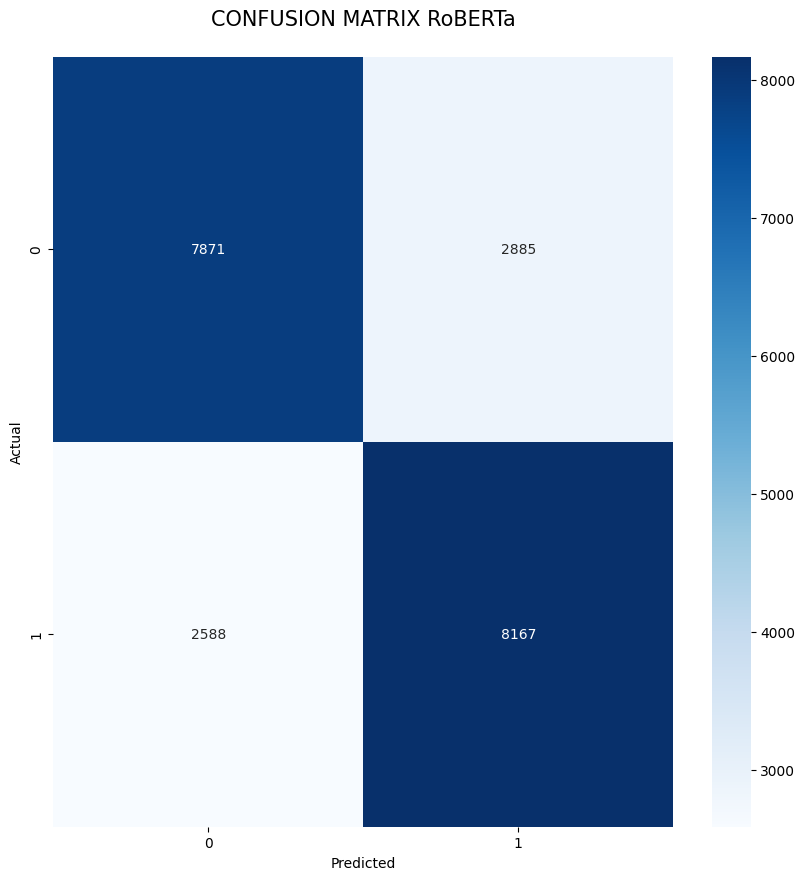

In [ ]:
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=15)

In [41]:
from tqdm import tqdm

In [42]:
def test_test(model):
    model.eval()
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(final_test_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs

In [43]:
class BERTDataset_test(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

In [44]:
final_test_dataset = BERTDataset_test(final_test_data, tokenizer, MAX_LEN)
len(final_test_dataset)

64533

In [45]:
final_test_dataset = BERTDataset_test(final_test_data, tokenizer, MAX_LEN)
final_test_loader = DataLoader(final_test_dataset, batch_size=1,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [46]:
len(final_test_loader)

64533

In [47]:
fin_outputs_R = test_test(model_R)

48330it [09:39, 83.41it/s]


KeyboardInterrupt: 

In [ ]:
np.savetxt("Roberta_fin_test_outputs_bin_ruatd.csv", fin_outputs_R, delimiter=";")

In [ ]:
len(fin_outputs_R)

64533

-------------------------------------

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('linhd-postdata/alberti-bert-base-multilingual-cased', max_len=512)

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)
train_for_test_loader = DataLoader(train_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('linhd-postdata/alberti-bert-base-multilingual-cased')
        self.fc = torch.nn.Linear(768, 2)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model_A = BERTClass()

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/712M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at linhd-postdata/alberti-bert-base-multilingual-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_A.load_state_dict(torch.load('/kaggle/input/outputs-models-weights/Model_A_3ep_32bs_200len_weights_ruatd.pth'))
model_A.to(device);

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model_A.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(EPOCHS):
  train(epoch, model_A)

Epoch: 0, Loss:  0.6884908080101013
Epoch: 0, Loss:  0.5886133313179016
Epoch: 0, Loss:  0.4591110348701477
Epoch: 1, Loss:  0.45601361989974976
Epoch: 1, Loss:  0.41932499408721924
Epoch: 1, Loss:  0.3767671585083008
Epoch: 2, Loss:  0.1770232915878296
Epoch: 2, Loss:  0.4585569202899933
Epoch: 2, Loss:  0.5080710649490356


In [ ]:
torch.save(model_A.state_dict(), 'Model_A_3ep_32bs_200len_weights_ruatd.pth')

In [ ]:
test_outputs_A, test_targets_A = test(model_A)

In [ ]:
train_outputs_A, train_targets_A = test_model_by_train(model_A)

In [ ]:
np.savetxt("Alberti_outputs_train_bin_ruatd.csv", train_outputs_A, delimiter=";")
np.savetxt("Alberti_outputs_bin_ruatd.csv", test_outputs_A, delimiter=";")

In [ ]:
from sklearn import metrics

outputs = np.array(test_outputs_A) >= 0.5
accuracy = metrics.accuracy_score(test_targets_A, outputs)
f1_score_micro = metrics.f1_score(test_targets_A, outputs, average='micro')
f1_score_macro = metrics.f1_score(test_targets_A, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.7435265678025197
F1 Score (Micro) = 0.7442443954001626
F1 Score (Macro) = 0.737634728365153


In [ ]:
new_outputs = []
for each in test_outputs_A:
    if each[0]>0.5:
      new_outputs.append('0')
    else:
      new_outputs.append('1')

In [ ]:
new_targets = []
for each in test_targets_A:
    if each[0]:
        new_targets.append('0')
    else:
        new_targets.append('1')

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

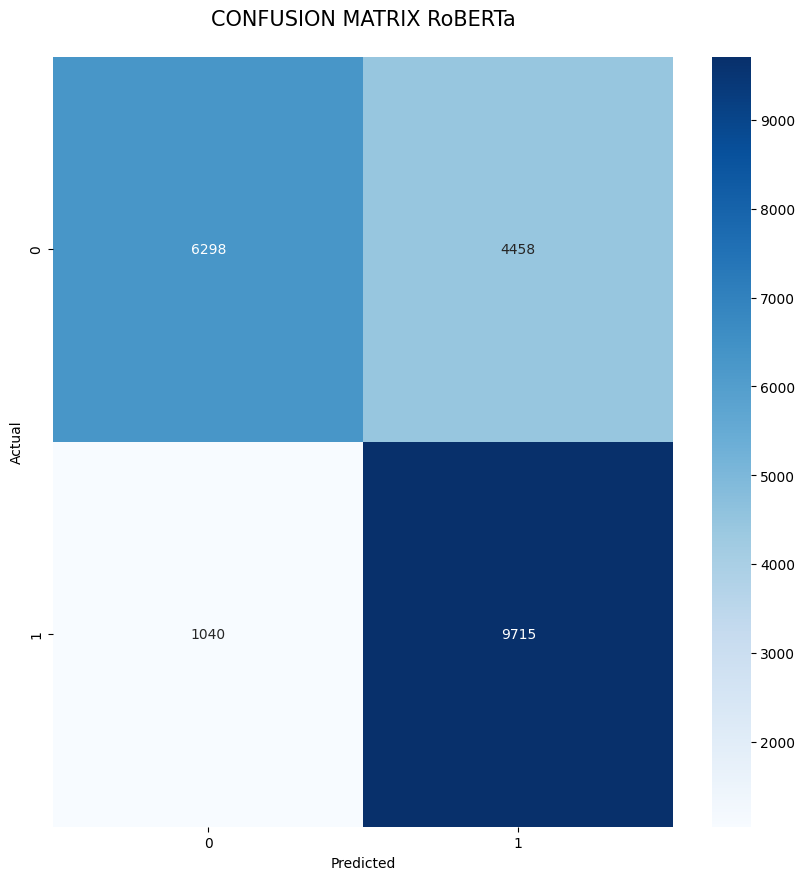

In [ ]:
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=15)

In [ ]:
class BERTDataset_test(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

In [ ]:
final_test_dataset = BERTDataset_test(final_test_data, tokenizer, MAX_LEN)
final_test_loader = DataLoader(final_test_dataset, batch_size=1,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [ ]:
def test_test(model):
    model.eval()
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(final_test_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs

In [ ]:
fin_outputs_A = test_test(model_A)

64533it [14:37, 73.52it/s]


In [ ]:
np.savetxt("Alberti_fin_test_outputs_bin_ruatd.csv", fin_outputs_A, delimiter=";")

---------------------------------------

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('ai-forever/ruBert-base', max_len=512)

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)
train_for_test_loader = DataLoader(train_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('ai-forever/ruBert-base')
        self.fc = torch.nn.Linear(768, 2)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model_B = BERTClass()


pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
model_B.load_state_dict(torch.load('/kaggle/input/outputs-models-weights/Model_B_3ep_32bs_128len_weights_ruatd.pth'))
model_B.to(device);

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model_B.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train(epoch, model):
    model.train()
    for _,data in enumerate(train_loader, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      loss = loss_fn(outputs, targets)
      if _%1500 == 0:
          print(f'Epoch: {epoch}, Loss:  {loss.item()}')

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

In [ ]:
def test(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
def test_model_by_train(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_for_test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
for epoch in range(EPOCHS):
  train(epoch, model_B)

In [ ]:
for epoch in range(1):
  train(epoch, model_B)

Epoch: 0, Loss:  0.33602362871170044
Epoch: 0, Loss:  0.38367992639541626
Epoch: 0, Loss:  0.3350638151168823


In [ ]:
test_outputs, test_targets = test(model_B)

In [ ]:
train_outputs, train_targets = test_model_by_train(model_B)

In [ ]:
np.savetxt("BERT_outputs_ruatd_bin.csv", test_outputs, delimiter=";")
np.savetxt("BERT_outputs_train_ruatd_bin.csv", train_outputs, delimiter=";")

In [ ]:
train_outputs = np.array(train_outputs) >= 0.5

In [ ]:
targets = []
for each in train_targets:
    if each[0] > 0:
        targets.append('1')
    else:
       targets.append('2')

In [ ]:
outputs = []
for each in train_outputs:
    if each[0]:
        outputs.append('1')
    else:
        outputs.append('2')

In [ ]:
torch.save(model_B.state_dict(), 'Model_B_3ep_32bs_128len_weights_ruatd.pth')

In [ ]:
test_outputs = np.array(test_outputs) >= 0.5
accuracy = metrics.accuracy_score(test_targets, test_outputs)
f1_score_micro = metrics.f1_score(test_targets, test_outputs, average='micro')
f1_score_macro = metrics.f1_score(test_targets, test_outputs, average='macro')
f1_score_weighted = metrics.f1_score(test_targets, test_outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.7985216865789596
F1 Score (Micro) = 0.801702285993349
F1 Score (Macro) = 0.801519629862902
F1 Score (Weighted) = 0.8015199092308773


In [ ]:
test_outputs

array([[False,  True],
       [ True, False],
       [False,  True],
       ...,
       [False,  True],
       [False,  True],
       [False,  True]])

In [ ]:
new_outputs = []
for each in test_outputs:
    if each[0]:
      new_outputs.append('0')
    else:
      new_outputs.append('1')

In [ ]:
new_targets = []
for each in test_targets:
    if each[0]:
        new_targets.append('0')
    else:
        new_targets.append('1')

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

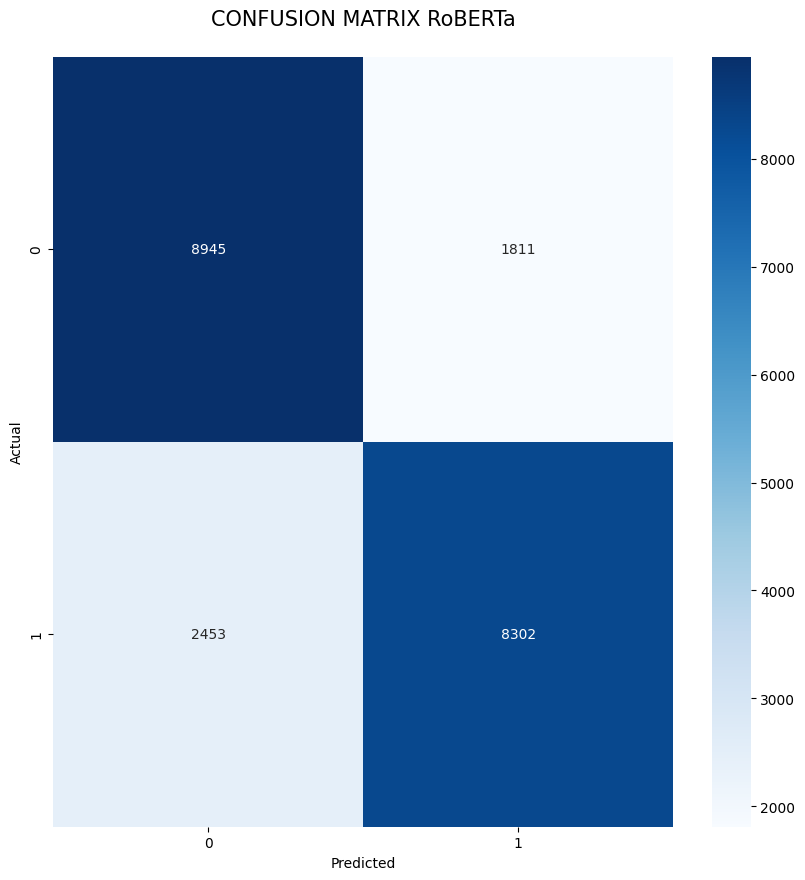

In [ ]:
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=15)

In [ ]:
class BERTDataset_test(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

In [ ]:
final_test_dataset = BERTDataset_test(final_test_data, tokenizer, MAX_LEN)
final_test_loader = DataLoader(final_test_dataset, batch_size=1,
                          num_workers=2, shuffle=False)

In [ ]:
def test_test(model):
    model.eval()
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(final_test_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs

In [ ]:
fin_outputs_B = test_test(model_B)

64533it [14:40, 73.29it/s]


In [ ]:
np.savetxt("Bert_fin_test_outputs_bin_ruatd.csv", fin_outputs_B, delimiter=";")

--------------------------------------------------

In [17]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained('ai-forever/ruRoberta-large', max_len=256)

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

In [21]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

In [22]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [23]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)
train_for_test_loader = DataLoader(train_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [25]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('ai-forever/ruRoberta-large')
        self.fc = torch.nn.Linear(1024, 2)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model_R = BERTClass()


pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# model_R.load_state_dict(torch.load('/kaggle/input/outputs-models-weights/Model_R_3ep_32bs_128len_weights_ruatd.pth'))
model_R.to(device);

In [27]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model_R.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
def train(epoch, model):
    model.train()
    for _,data in enumerate(train_loader, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      loss = loss_fn(outputs, targets)
      if _%1500 == 0:
          print(f'Epoch: {epoch}, Loss:  {loss.item()}')

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

In [29]:
def test(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [30]:
def test_model_by_train(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_for_test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [31]:
for epoch in range(EPOCHS):
  train(epoch, model_R)

Epoch: 0, Loss:  0.6894937753677368
Epoch: 0, Loss:  0.6920888423919678
Epoch: 0, Loss:  0.7151675224304199
Epoch: 0, Loss:  0.6930657625198364
Epoch: 0, Loss:  0.691774845123291
Epoch: 0, Loss:  0.6885986328125
Epoch: 1, Loss:  0.6989513635635376


KeyboardInterrupt: 

In [32]:
test_outputs, test_targets = test(model_R)

In [33]:
train_outputs, train_targets = test_model_by_train(model_R)

In [34]:
np.savetxt("Roberta_large_outputs_ruatd_bin.csv", test_outputs, delimiter=";")
np.savetxt("Roberta_large_outputs_train_ruatd_bin.csv", train_outputs, delimiter=";")

In [35]:
train_outputs = np.array(train_outputs) >= 0.5

In [36]:
targets = []
for each in train_targets:
    if each[0] > 0:
        targets.append('1')
    else:
       targets.append('2')

In [37]:
outputs = []
for each in train_outputs:
    if each[0]:
        outputs.append('1')
    else:
        outputs.append('2')

In [38]:
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.49998450405219036
F1 Score (Micro) = 0.49998450405219036
F1 Score (Macro) = 0.3333264461742692
F1 Score (Weighted) = 0.33331611575584225


In [39]:
torch.save(model_R.state_dict(), 'Model_R_l_1ep_32bs_128len_weights_ruatd.pth')

In [40]:
test_outputs = np.array(test_outputs) >= 0.5
accuracy = metrics.accuracy_score(test_targets, test_outputs)
f1_score_micro = metrics.f1_score(test_targets, test_outputs, average='micro')
f1_score_macro = metrics.f1_score(test_targets, test_outputs, average='macro')
f1_score_weighted = metrics.f1_score(test_targets, test_outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.4999767560782855
F1 Score (Micro) = 0.4999767560782855
F1 Score (Macro) = 0.3333230025413748
F1 Score (Weighted) = 0.3333075070738214


In [41]:
test_outputs

array([[False,  True],
       [False,  True],
       [False,  True],
       ...,
       [False,  True],
       [False,  True],
       [False,  True]])

In [42]:
new_outputs = []
for each in test_outputs:
    if each[0]:
      new_outputs.append('0')
    else:
      new_outputs.append('1')

In [43]:
new_targets = []
for each in test_targets:
    if each[0]:
        new_targets.append('0')
    else:
        new_targets.append('1')

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

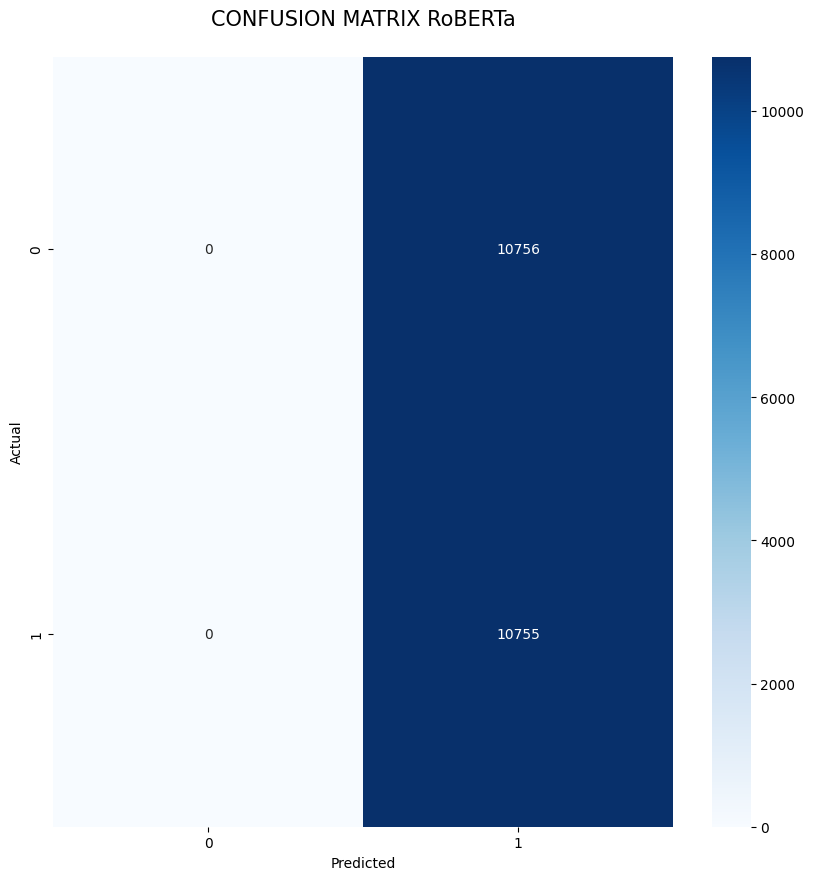

In [44]:
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=15)

In [ ]:
from tqdm import tqdm

In [ ]:
def test_test(model):
    model.eval()
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(final_test_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs

In [ ]:
class BERTDataset_test(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

In [ ]:
final_test_dataset = BERTDataset_test(final_test_data, tokenizer, MAX_LEN)
len(final_test_dataset)

64533

In [ ]:
final_test_dataset = BERTDataset_test(final_test_data, tokenizer, MAX_LEN)
final_test_loader = DataLoader(final_test_dataset, batch_size=1,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [ ]:
len(final_test_loader)

64533

In [ ]:
fin_outputs_R = test_test(model_R)

64533it [13:04, 82.27it/s]


In [ ]:
np.savetxt("Roberta_fin_test_outputs_bin_ruatd.csv", fin_outputs_R, delimiter=";")

In [ ]:
len(fin_outputs_R)

64533

-----------------------------------------------------------

In [ ]:
df_train_R = pd.read_csv("/kaggle/input/outputs-models-weights/Roberta_outputs_train_ruatd_bin.csv", header=None, sep=';')
df_train_A = pd.read_csv("/kaggle/input/outputs-models-weights/Alberti_outputs_train_bin_ruatd (1).csv", header=None, sep=';')
df_train_B = pd.read_csv("/kaggle/input/outputs-models-weights/BERT_outputs_train_ruatd_bin.csv", header=None, sep=';')
df_train_R = df_train_R.rename(columns={0: 'R_0', 1: 'R_1'})
df_train_A = df_train_A.rename(columns={0: 'A_0', 1: 'A_1'})
df_train_B = df_train_B.rename(columns={0: 'B_0', 1: 'B_1'})

In [ ]:
df_train_B

,B_0,B_1
0,0.981890,0.018949
1,0.856973,0.149304
2,0.775697,0.221509
3,0.024479,0.975232
4,0.136845,0.863878
...,...,...
129061,0.001530,0.998440
129062,0.718190,0.287761
129063,0.604794,0.375164
129064,0.282203,0.727787


In [ ]:
df_train = pd.concat([
    df_train_R, df_train_A, df_train_B], axis=1)

In [ ]:
y_train = train['Class']
y_train

0         H
1         H
2         H
3         M
4         M
         ..
129061    M
129062    H
129063    H
129064    M
129065    M
Name: Class, Length: 129066, dtype: object

In [ ]:
y_train = train['Class'].apply(lambda x: x.replace('H', '0'))
y_train = y_train.apply(lambda x: x.replace('M', '1'))
y_train = y_train.astype('float64')
y_train

0         0.0
1         0.0
2         0.0
3         1.0
4         1.0
         ... 
129061    1.0
129062    0.0
129063    0.0
129064    1.0
129065    1.0
Name: Class, Length: 129066, dtype: float64

In [ ]:
from sklearn.svm import LinearSVC
import optuna
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [ ]:
X_train, X_valid, train_labels, valid_labels = train_test_split(df_train, y_train, test_size=0.2, random_state=42, shuffle=True, stratify=y_train)

In [ ]:
def objective(trial):
    global X_train, train_labels, X_valid, valid_labels

    c = trial.suggest_float("svc_c", 1e-4, 1e3, log=True)

    clf = LinearSVC(C=c, random_state=42, class_weight='balanced', max_iter=100000)
    clf.fit(X_train, train_labels)

    return metrics.f1_score(clf.predict(X_valid), valid_labels, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2024-03-27 14:57:16,301] A new study created in memory with name: no-name-6144be11-eb5c-470b-bec4-412c8d91ddd4
[I 2024-03-27 14:57:22,054] Trial 0 finished with value: 0.9580847350470043 and parameters: {'svc_c': 20.880297107566793}. Best is trial 0 with value: 0.9580847350470043.
[I 2024-03-27 14:57:22,290] Trial 1 finished with value: 0.95785232414598 and parameters: {'svc_c': 0.00042511954546137643}. Best is trial 0 with value: 0.9580847350470043.
[I 2024-03-27 14:57:22,500] Trial 2 finished with value: 0.9578910440505379 and parameters: {'svc_c': 0.002119392123150249}. Best is trial 0 with value: 0.9580847350470043.
[I 2024-03-27 14:57:50,975] Trial 3 finished with value: 0.9580847297632673 and parameters: {'svc_c': 95.22131593708505}. Best is trial 0 with value: 0.9580847350470043.
[I 2024-03-27 14:57:51,205] Trial 4 finished with value: 0.9575424178230416 and parameters: {'svc_c': 0.0006687133749866585}. Best is trial 0 with value: 0.9580847350470043.
[I 2024-03-27 14:57:51,43

KeyboardInterrupt: 

In [ ]:
def objective(trial):
    global X_train, train_labels, X_valid, valid_labels

    c = trial.suggest_float("lr_c", 1e-2, 1e3, log=True)

    clf = LogisticRegression(C=c, random_state=42, class_weight='balanced', max_iter=100000)
    clf.fit(X_train, train_labels)

    return metrics.f1_score(clf.predict(X_valid), valid_labels, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

In [ ]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier()
clf.fit(df_train, y_train)

In [ ]:
df_test_R = pd.read_csv("/kaggle/input/outputs-models-weights/Roberta_outputs_ruatd_bin.csv", header=None, sep=';')
df_test_A = pd.read_csv("/kaggle/input/outputs-models-weights/Alberti_outputs_bin_ruatd (1).csv", header=None, sep=';')
df_test_B = pd.read_csv("/kaggle/input/outputs-models-weights/BERT_outputs_ruatd_bin.csv", header=None, sep=';')
df_test_R = df_test_R.rename(columns={0: 'R_0', 1: 'R_1'})
df_test_A = df_test_A.rename(columns={0: 'A_0', 1: 'A_1'})
df_test_B = df_test_B.rename(columns={0: 'B_0', 1: 'B_1'})

In [ ]:
df_test = pd.concat([
    df_test_R, df_test_A, df_test_B], axis=1)

In [ ]:
y_pred = clf.predict(df_test)

In [ ]:
test_labels = test['Class'].apply(lambda x: x.replace('H', '0'))
test_labels = test_labels.apply(lambda x: x.replace('M', '1'))
test_labels = test_labels.astype('float64')
test_labels

0        0.0
1        0.0
2        1.0
3        0.0
4        1.0
        ... 
21506    0.0
21507    1.0
21508    1.0
21509    1.0
21510    1.0
Name: Class, Length: 21511, dtype: float64

In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.8107479894007718
F1 Score (Micro) = 0.8107479894007718
F1 Score (Macro) = 0.810747398808377


Text(0.5, 1.0, 'CONFUSION MATRIX\n')

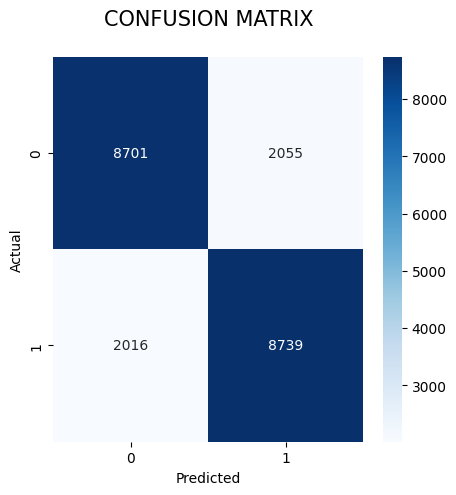

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=15)

In [ ]:
clf = LinearSVC(C=0.026, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(df_train, y_train)

LinearSVC(C=0.026, class_weight='balanced', max_iter=100000, random_state=42)

In [ ]:
y_pred = clf.predict(df_test)

In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.8110269164613454
F1 Score (Micro) = 0.8110269164613454
F1 Score (Macro) = 0.8110269148277716


Text(0.5, 1.0, 'CONFUSION MATRIX\n')

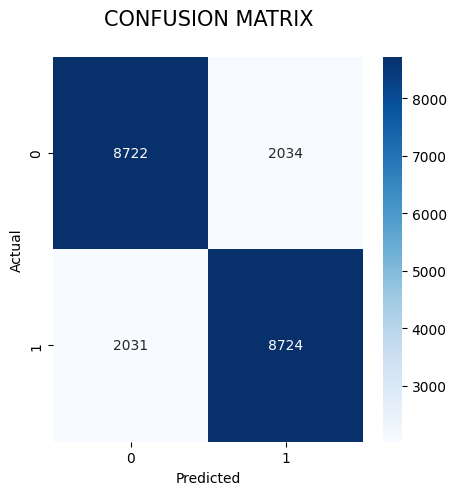

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=15)

In [ ]:
clf = LogisticRegression(C=60, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(df_train, y_train)

LogisticRegression(C=60, class_weight='balanced', max_iter=100000,
                   random_state=42)

In [ ]:
y_pred = clf.predict(df_test)

In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.8117707219562085
F1 Score (Micro) = 0.8117707219562085
F1 Score (Macro) = 0.8117705250715883


Text(0.5, 1.0, 'CONFUSION MATRIX\n')

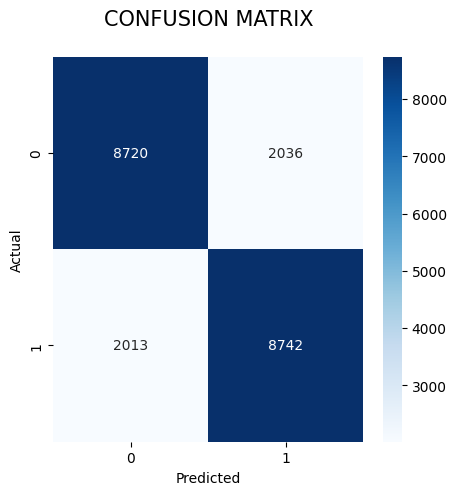

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=15)

In [ ]:
final_test_data

,Id,Text
0,8,Деятельность по созданию новых рабочих мест и ...
1,12,12-18 июля 1944 года в схватке за мост на реке...
2,14,В целях реализации Федерального закона от 08.0...
3,16,Студент медик сказал что моя бессонница обосно...
4,17,В 1542 году король вновь заставил его внести в...
...,...,...
64528,215100,Вчера по дороге к Теплицу продолжали путь к Те...
64529,215101,Одной из приоритетных сфер деятельности В. П. ...
64530,215103,"Кстати, выбрать квартиру от ПЗСП и забронирова..."
64531,215108,Обама использовал это при планировании использ...


------------------------------------------

In [49]:
df_final_test_R = pd.read_csv("/kaggle/input/outputs-models-weights/Roberta_fin_test_outputs_bin_ruatd (2).csv", header=None, sep=';')
df_final_test_A = pd.read_csv("/kaggle/input/outputs-models-weights/Alberti_fin_test_outputs_bin_ruatd (1).csv", header=None, sep=';')
df_final_test_B = pd.read_csv("/kaggle/input/outputs-models-weights/Bert_fin_test_outputs_bin_ruatd (1).csv", header=None, sep=';')

In [50]:
df_final_test_R = df_final_test_R.rename(columns={0: 'R_0', 1: 'R_1'})
df_final_test_A = df_final_test_A.rename(columns={0: 'A_0', 1: 'A_1'})
df_final_test_B = df_final_test_B.rename(columns={0: 'B_0', 1: 'B_1'})

In [51]:
final_test_data

,Id,Text
0,8,Деятельность по созданию новых рабочих мест и ...
1,12,12-18 июля 1944 года в схватке за мост на реке...
2,14,В целях реализации Федерального закона от 08.0...
3,16,Студент медик сказал что моя бессонница обосно...
4,17,В 1542 году король вновь заставил его внести в...
...,...,...
64528,215100,Вчера по дороге к Теплицу продолжали путь к Те...
64529,215101,Одной из приоритетных сфер деятельности В. П. ...
64530,215103,"Кстати, выбрать квартиру от ПЗСП и забронирова..."
64531,215108,Обама использовал это при планировании использ...


In [52]:
df_final_test = pd.concat([df_final_test_R, df_final_test_A, df_final_test_B], axis=1)
len(df_final_test)

64533

In [ ]:
df_final_test.head(2)

,R_0,R_1,A_0,A_1,B_0,B_1
0,0.002245,0.997603,0.001329,0.998683,0.001637,0.998386
1,0.997926,0.001975,0.998567,0.001450,0.998388,0.001652


In [ ]:
clf = LogisticRegression(C=60, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(df_train, train['Class'])

LogisticRegression(C=60, class_weight='balanced', max_iter=100000,
                   random_state=42)

In [ ]:
clf = LinearSVC(C=0.026, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(df_train, train['Class'])

LinearSVC(C=0.026, class_weight='balanced', max_iter=100000, random_state=42)

In [ ]:
final_preds = clf.predict(df_final_test)

In [ ]:
final_preds = pd.concat([final_test_data['Id'],
    pd.DataFrame(final_preds)], axis=1)

In [ ]:
final_preds = final_preds.rename(columns={0: 'Class'})

In [ ]:
final_preds

,Id,Class
0,8,M
1,12,H
2,14,H
3,16,H
4,17,M
...,...,...
64528,215100,M
64529,215101,H
64530,215103,H
64531,215108,M


In [ ]:
final_preds.to_csv('output.csv', index=False)

In [54]:
df_final_test_R

,R_0,R_1
0,0.002245,0.997603
1,0.997926,0.001975
2,0.998616,0.001414
3,0.079195,0.921039
4,0.193965,0.806461
...,...,...
64528,0.872308,0.127328
64529,0.003442,0.996220
64530,0.789459,0.210203
64531,0.273856,0.729074


In [73]:
df_final_test_B

,B_0,B_1
0,0.001637,0.998386
1,0.998388,0.001652
2,0.998290,0.001726
3,0.930912,0.068367
4,0.614205,0.385439
...,...,...
64528,0.028969,0.973453
64529,0.998301,0.001746
64530,0.964780,0.032947
64531,0.433931,0.580993


In [97]:
new_targets = []
for each in df_final_test_A.A_0:
    if each>=0.5:
        new_targets.append('H')
    else:
        new_targets.append('M')

In [98]:
final_preds_A = pd.concat([final_test_data['Id'],
    pd.DataFrame(new_targets)], axis=1)

In [99]:
final_preds_A = final_preds_A.rename(columns={0: 'Class'})
final_preds_A

,Id,Class
0,8,M
1,12,H
2,14,H
3,16,H
4,17,M
...,...,...
64528,215100,M
64529,215101,H
64530,215103,H
64531,215108,H


In [100]:
final_preds_A.to_csv('output_A.csv', index=False)